In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from skimage import io

In [44]:
folder_path = "images/*"
images = []
for file in glob.glob(folder_path):
    print(file)
    # Flip channel due to legacy reasons
    img = cv2.imread(file)[:, :, ::-1]
    # Do yourself a favour and convert to float
    img = img.astype(float) / 255
    images.append(img)


images/smoothing.png
images/smoothing2.png
images/dragonbrother_dragonbrother_you_are_so_greater.png
images/harris.png


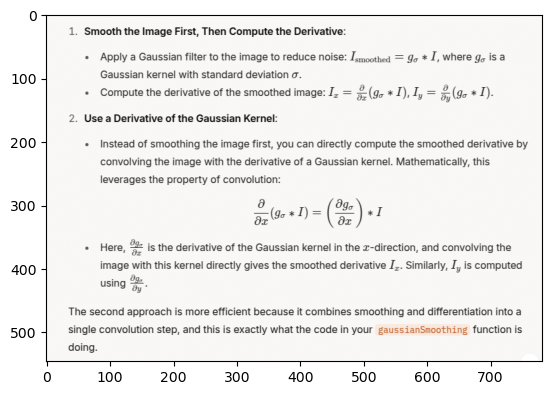

In [45]:
plt.imshow(images[0])

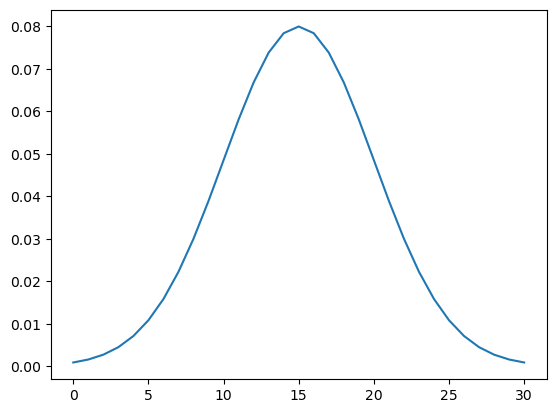

In [46]:
sigma = 5
d = np.ceil(3 * sigma)
x = np.arange(-d, d + 1)
# Naughty prof never put the constant at the front because he was lazy
# Only an approximation of the gaussian, wish that it could sum to 1 
# but with 3 sigmas ~ 99.7, image would be darker
g = np.exp(-x**2/(2*sigma**2))
g /= g.sum()
plt.plot(g)

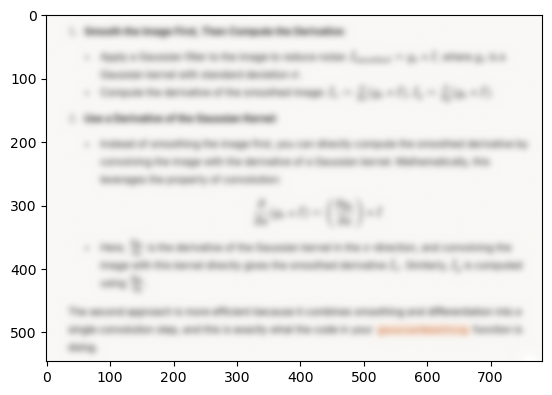

In [47]:
im = images[0]
# Only does the filter in onde direction
im_g = cv2.filter2D(im, -1, g)
# X and Y direction
im_sep_g = cv2.sepFilter2D(im, -1, g, g)
plt.imshow(im_sep_g)

## Exercise

(300, 300)

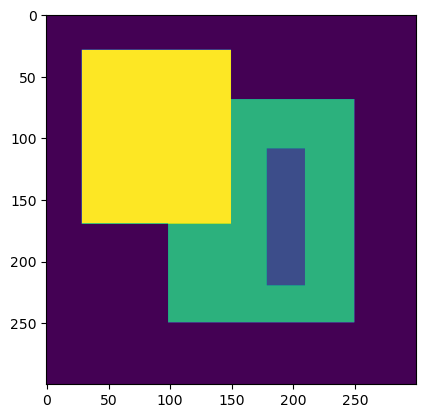

In [48]:
im1 = cv2.imread("images/harris.png")
im1 = im1.astype('float32') / 255
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
plt.imshow(im1)
im1.shape

## Ex 6.1

(31,) (31,)


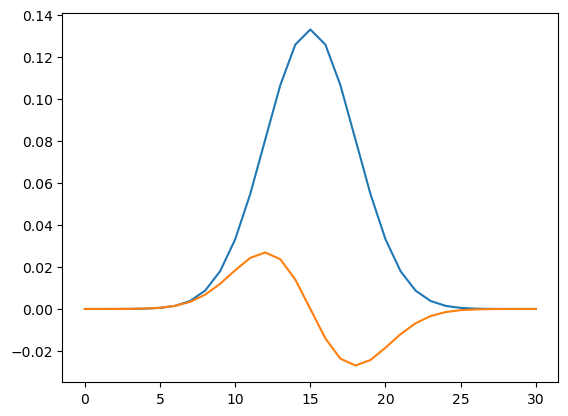

In [49]:
def gaussian1DKernel(sigma: int, length: int=5):
    """
    Generate the 1D gaussian kernel and its derivative
    Args:
        sigma (int): gaussian width
        length (int): length of the Gaussian kernel

    Return:
        g (np.array): gaussian kernel
        gd (np.array): derivative of gaussian kernel, g
    """
    x = np.arange(-np.ceil(length * sigma), np.ceil(length * sigma) + 1)
    constant = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    g = constant * np.exp(-(x**2) / (2 * sigma**2))
    g /= g.sum()
    gd = (-x / sigma**2) * g
    return g, gd
g, gd = gaussian1DKernel(3, 5)
print(g.shape, gd.shape)
plt.plot(g)
plt.plot(gd)


## Ex 6.2
![smoothing](images/smoothing.png)
![smoothing](images/smoothing2.png)

In [50]:
# # Flip channel due to legacy reasons
# im = cv2.imread(file)[:, :, ::-1]
def gaussianSmoothing(im: np.array, sigma: int):
    """
    Generate the gaussian smoothed image and its smoothed derivative in x and y direction
    Args:
        im (np.array): image to be smoothed
        sigma (int): gaussian width

    Return:
        I (np.array): gaussian smoothed image
        Ix (np.array): smoothed derivative of image im in x direction
        Iy (np.array): smoothed derivative of image im in y direction
    """
    g, gd = gaussian1DKernel(sigma)
    I = cv2.sepFilter2D(im, -1, g, g)
    Ix = cv2.sepFilter2D(im, -1, gd, g)
    Iy = cv2.sepFilter2D(im, -1, g, gd)
    return I, Ix, Iy


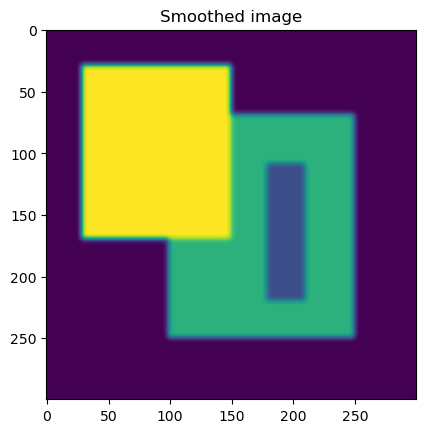

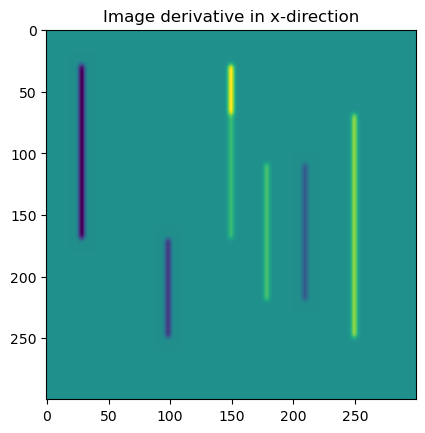

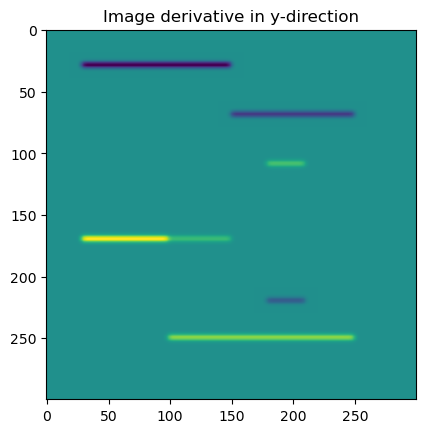

((300, 300), (300, 300), (300, 300))

In [51]:
im = "images/harris.png"
im = cv2.imread(im, cv2.IMREAD_GRAYSCALE).astype(float)
sigma = 2
I, Ix, Iy = gaussianSmoothing(im, sigma)
plt.imshow(I)
plt.title("Smoothed image")
plt.show()

plt.imshow(Ix)
plt.title("Image derivative in x-direction")
plt.show()

plt.imshow(Iy)
plt.title("Image derivative in y-direction")
plt.show()
I.shape, Ix.shape, Iy.shape

## Ex 6.3

In [52]:
def structureTensor(im: np.array, sigma: int, epsilon: int):
    """
    Generate the structure tensor. We use two Gaussian widths in this function: sigma and epsilon. The first one sigma is used
    to calculate the derivatives and the second one to calculate the structure tensor.
    Args:
        im (np.array): image
        sigma (int): first gaussian width
        epsilon (int): second gaussian width

    Return:
        C (np.array): structure tensor, also referred to as the second-moment matrix, is a matrix derived from the gradient of a function. It describes the distribution of the gradient in a specified neighborhood around a point and makes the information invariant to the observing coordinates.
    """
    _, Ix, Iy = gaussianSmoothing(im, sigma)
    g_eps, _ = gaussian1DKernel(epsilon)
    C = np.asarray(
        [
            [cv2.sepFilter2D(Ix**2, -1, g_eps, g_eps), cv2.sepFilter2D(Ix * Iy, -1, g_eps, g_eps)],
            [cv2.sepFilter2D(Ix*Iy, -1, g_eps, g_eps), cv2.sepFilter2D(Iy**2, -1, g_eps, g_eps)],
        ]
    )
    return C

Structure tensor: (2, 2, 300, 300)


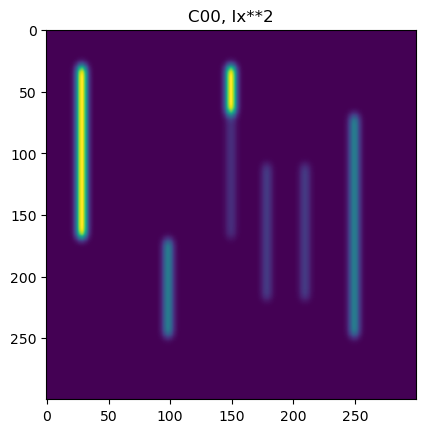

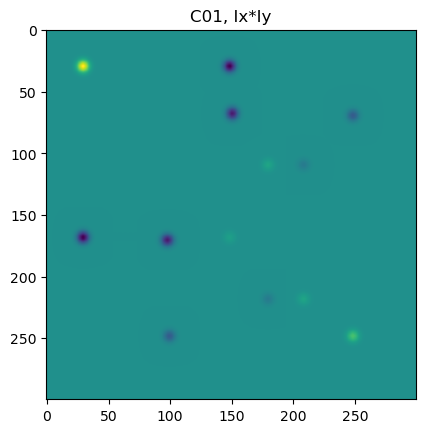

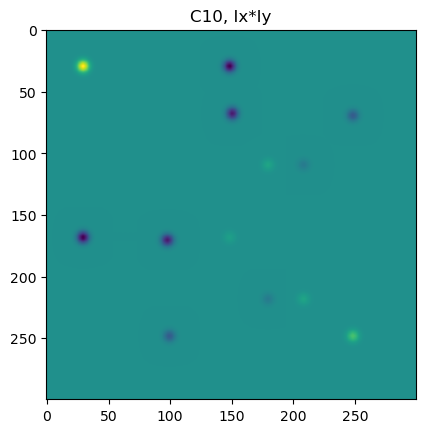

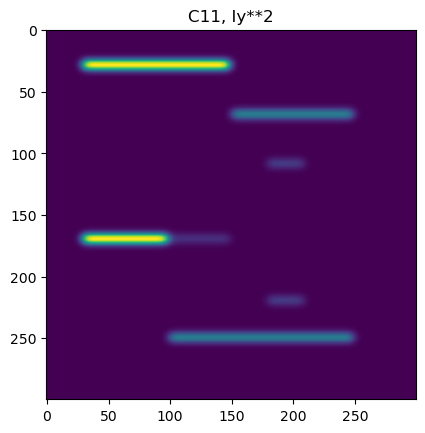

In [53]:
im = "images/harris.png"
im = cv2.imread(im, cv2.IMREAD_GRAYSCALE).astype(float)
sigma = 2
epsilon = 3
k = 0.06
C = structureTensor(im, sigma, epsilon)
print(f"Structure tensor: {C.shape}")

# Display images
plt.imshow(C[0, 0])
plt.title("C00, Ix**2")
plt.show()

plt.imshow(C[0, 1])
plt.title("C01, Ix*Iy")
plt.show()
plt.imshow(C[1, 0])
plt.title("C10, Ix*Iy")
plt.show()

plt.imshow(C[1, 1])
plt.title("C11, Iy**2")
plt.show()

## Ex 6.4

In [54]:
def harrisMeasure(im: np.array, sigma: int, epsilon: int, k: float):
    """
    Generate a measure how likely a pixel is a corner
    Args:
        im (np.array): image
        sigma (int): first gaussian width
        epsilon (int): second gaussian width
        k (float): free parameter for corner detection

    Return:
        r (np.array): a measure how likely a pixel is a corner
    """
    C = structureTensor(im, sigma, epsilon)
    a = C[0, 0]
    b = C[1, 1]
    c = C [0, 1]
    r = a * b - c**2 - k * (a + b) **2
    return r

(300, 300)


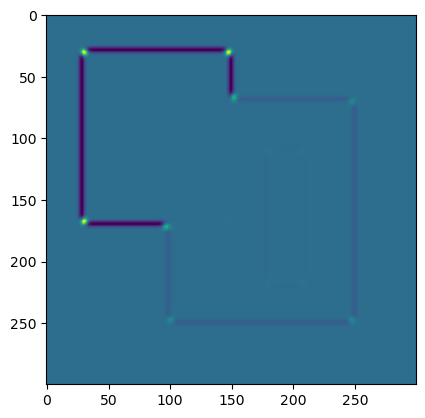

In [55]:
im = "images/harris.png"
im = cv2.imread(im, cv2.IMREAD_GRAYSCALE).astype(float)
sigma = 2
epsilon = 2
k = 0.06
r = harrisMeasure(im, sigma, epsilon, k)
print(r.shape)
plt.imshow(r)

## Ex 6.5

In [56]:
tau = 0.6
local_maximums = r > tau
local_maximums

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [57]:
from scipy.ndimage import maximum_filter

In [70]:
def cornerDetector(im: np.array, sigma: int, epsilon: int, k: float, tau: float):
    """
        Detect corners in an image
        Args:
            im (np.array): image to be smoothed
            sigma (int): first gaussian width
            epsilon (int): second gaussian width
            k (float): free parameter for corner detection
            tau (float): relative threshold

        Return:
            c (np.array): list of points where r is the local maximum and larger than tau
    """
    r = harrisMeasure(im, sigma, epsilon, k)
    footprint = np.ones((3,3), dtype=bool)
    r_max = maximum_filter(r, footprint=footprint, mode="constant", cval=0.0)
    local_maxima = (r == r_max) & (r > tau)
    corner_coords = np.where(local_maxima)
    c = np.column_stack((corner_coords[0], corner_coords[1]))
    return c

In [72]:
tau = 0.6
sigma = 2
epsilon = 2
k = 0.06
c =cornerDetector(im, sigma, epsilon, k, tau)

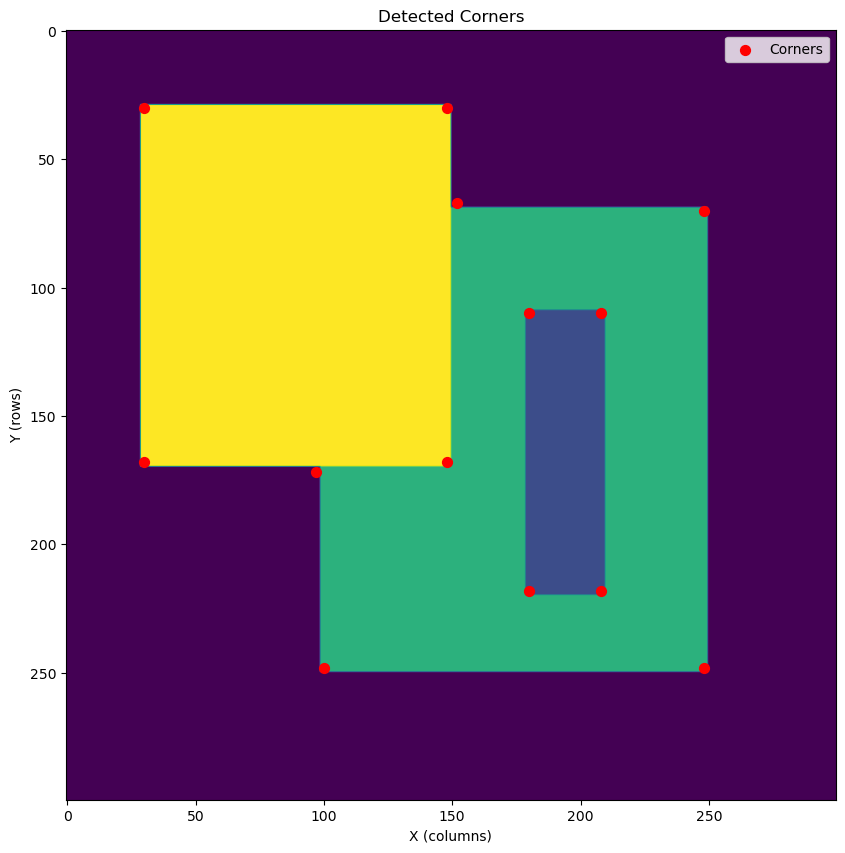

In [73]:
plt.figure(figsize=(10, 10))

plt.imshow(im)

if len(c) > 0:  # Only plot if there are corners
    # c[:, 1] is the x-coordinate (col), c[:, 0] is the y-coordinate (row)
    plt.scatter(c[:, 1], c[:, 0], c="red", s=50, marker="o", label="Corners")

# Add labels and title
plt.title("Detected Corners")
plt.xlabel("X (columns)")
plt.ylabel("Y (rows)")
plt.legend()

plt.show()

## Ex 6.6

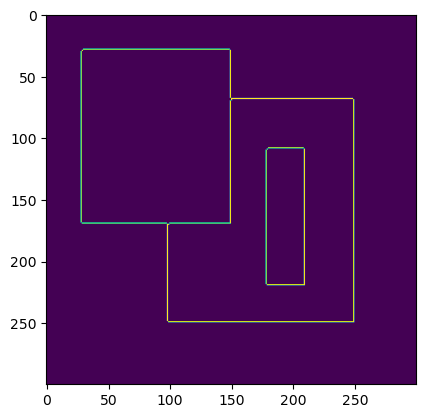

In [77]:
im_path = "images/harris.png"
im = cv2.imread(im_path)
t_lower = 50  # Lower Threshold
t_upper = 150  # Upper threshold

# Applying the Canny Edge filter
edge = cv2.Canny(im, t_lower, t_upper)
plt.imshow(edge)